
# Set up the notebook

In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

from stats_scraping_utils import StatsScrapingUtilities
from storage import Storage
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
import numpy as np
import re
from scipy.stats import pearsonr
%matplotlib inline

# Use the following only if you are on a high definition device
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

s = Storage()
ssu = StatsScrapingUtilities(s=s)


----


# Prepare the Countries scatterplot

In [4]:

all_countries_df = s.load_object('all_countries_df')
income_inequality_countries_df = s.load_object('income_inequality_countries_df')

In [6]:

columns_set = set(all_countries_df.columns).union(set(income_inequality_countries_df.columns))
print([cn for cn in columns_set if 'murder' in cn])
columns_set

[]


{'country_name', 'inkscape_cy', 'svg_height', 'cc_tld', 'code_notes', 'gini_index', 'year_code_established', 'short_form_name', 'pwrindx_score', 'inkscape_zoom', 'intra_country_borders_d', 'inkscape_cx', 'svg_width', 'wikipedia_title', 'country_code', 'wikipedia_url', 'iso_3166_2', 'pwrindx_rank', 'country_population_2022', 'legend_transform', 'font_size'}

In [10]:

import os

[f's.{fn}' for fn in dir(s) if 'pic' in fn]

['s.attempt_to_pickle', 's.pickle_exists', 's.saves_pickle_folder']

In [22]:

for file_name in os.listdir(s.saves_pickle_folder):
    if file_name.endswith('_df.pkl'):
        df_name = file_name.split('.')[0]
        df = eval(f"s.load_object('{df_name}')")
        columns_list = [cn for cn in df.columns if (('murder' in str(cn)) or ('cide' in str(cn)))]
        if columns_list:
            print()
            print(df_name)
            print(columns_list)


freedom_df
['pf_ss_homicide']

merge_df
['pf_ss_homicide']

race_homicide_rate_by_state_year_df
['Homicide_Rate_Per_100_000']

state_merge_df
['Homicide_Rate_2018', 'Homicide_Rate_2017', 'Homicide_Rate_2014', 'Homicide_Rate_2010', 'Homicide_Rate_2005', 'Homicide_Rate_2000', 'Homicide_Rate_1996', 'Suicide_Rate_2017', 'Suicide_Deaths_2017', 'Suicide_Rate_2016', 'Suicide_Deaths_2016', 'Suicide_Rate_2015', 'Suicide_Deaths_2015', 'Suicide_Rate_2014', 'Suicide_Deaths_2014', 'Suicide_Rate_2005', 'Suicide_Deaths_2005', 'Gun_Suicide_Deaths', 'Gun_Suicide_Rate']

us_states_df
['homicide_rate_2018', 'homicide_rate_2017', 'homicide_rate_2014', 'homicide_rate_2010', 'homicide_rate_2005', 'homicide_rate_2000', 'homicide_rate_1996']

us_stats_df
['Homicide_Rate_2018', 'Homicide_Rate_2017', 'Homicide_Rate_2014', 'Homicide_Rate_2010', 'Homicide_Rate_2005', 'Homicide_Rate_2000', 'Homicide_Rate_1996', 'Suicide_Rate_2017', 'Suicide_Deaths_2017', 'Suicide_Rate_2016', 'Suicide_Deaths_2016', 'Suicide_Rate_2


## Clean and prepare Murder Countries dataset

In [246]:

%run ../load_magic/soup.py

if s.pickle_exists('murder_rates_countries_df'):
    murder_rates_df = s.load_object('murder_rates_countries_df')
else:
    wiki_url = 'https://en.wikipedia.org/wiki/List_of_countries_by_intentional_homicide_rate'
    table_dfs_list = get_wiki_tables(wiki_url, verbose=True)
    murder_rates_df = table_dfs_list[1].copy()
    murder_rates_df.columns = ['country_name', 'Region', 'Subregion', 'murder_rate', 'Count', 'Year', 'Source']
    murder_rates_df.country_name = murder_rates_df.country_name.map(lambda x: str(x).split('*')[0].strip())
    
    country_name = 'St. Pierre & Miquelon'
    fix_me = 'Saint Pierre and Miquelon'
    mask_series = (murder_rates_df.country_name == fix_me)
    murder_rates_df.loc[mask_series, 'country_name'] = country_name

    country_name = 'St. Vincent & Grenadines'
    fix_me = 'Saint Vincent and the Grenadines'
    mask_series = (murder_rates_df.country_name == fix_me)
    murder_rates_df.loc[mask_series, 'country_name'] = country_name

    country_name = 'St. Kitts & Nevis'
    fix_me = 'Saint Kitts and Nevis '
    mask_series = (murder_rates_df.country_name == fix_me)
    murder_rates_df.loc[mask_series, 'country_name'] = country_name

    country_name = 'St. Lucia'
    fix_me = 'Saint Lucia '
    mask_series = (murder_rates_df.country_name == fix_me)
    murder_rates_df.loc[mask_series, 'country_name'] = country_name
    
    country_name = 'Turkiye'
    fix_me = 'Turkey '
    mask_series = (murder_rates_df.country_name == fix_me)
    murder_rates_df.loc[mask_series, 'country_name'] = country_name
    
    murder_rates_df.dropna(axis='index', how='any', subset=['country_name', 'murder_rate'], inplace=True)
    murder_rates_df['log_murder_rate'] = murder_rates_df.murder_rate.map(lambda x: np.log(float(x)))
    s.store_objects(murder_rates_countries_df=murder_rates_df)
murder_rates_df

,country_name,Region,Subregion,murder_rate,Count,Year,Source,log_murder_rate
1,Afghanistan,Asia,Southern Asia,6.7,2474.0,2018.0,NSO,1.902108
2,Albania,Europe,Southern Europe,2.1,61.0,2020.0,NSO,0.741937
3,Algeria,Africa,Northern Africa,1.3,580.0,2020.0,CTS,0.262364
4,Andorra,Europe,Southern Europe,2.6,2.0,2020.0,CTS,0.955511
5,Angola,Africa,Middle Africa,4.8,1217.0,2012.0,NSO,1.568616
...,...,...,...,...,...,...,...,...
191,Venezuela,Americas,South America,36.7,10598.0,2018.0,CTS,3.602777
192,Vietnam,Asia,South-Eastern Asia,1.5,1358.0,2011.0,WHO,0.405465
193,Yemen,Asia,Western Asia,6.8,1703.0,2013.0,NSO,1.916923
194,Zambia,Africa,Eastern Africa,5.4,853.0,2015.0,NP,1.686399


In [170]:

%run ../load_magic/lists.py

df = check_for_typos(all_countries_df.country_name, murder_rates_df.country_name, verbose=False)

In [171]:

mask_series = (df.max_similarity < 1.)
df[mask_series].sort_values('max_similarity', ascending=False).head(20)

,left_item,right_item,max_similarity
83,Gambia,Zambia,0.833333
119,North Korea,South Korea,0.818182
143,Mali,Malawi,0.800000
14,Åland Islands,Cayman Islands,0.740741
149,Mauritania,Mauritius,0.736842
204,Somalia,Romania,0.714286
72,Faroe Islands,Channel Islands,0.714286
141,Marshall Islands,Channel Islands,0.709677
139,St. Martin,San Marino,0.700000
44,Cook Islands,Cayman Islands,0.692308


In [154]:

mask_series = (df.max_similarity < 1.)
for row_index, row_series in df[mask_series].sort_values('max_similarity', ascending=False).head(16).iterrows():
    country_name = row_series.left_item
    fix_me = row_series.right_item
    mask_series = (murder_rates_df.country_name == fix_me)
    murder_rates_df.loc[mask_series, 'country_name'] = country_name

In [157]:

mask_series = (df.max_similarity < 1.)
for row_index, row_series in df[mask_series].sort_values('max_similarity', ascending=False).head(7).iterrows():
    country_name = row_series.left_item
    fix_me = row_series.right_item
    print(f'''
country_name = '{country_name}'
fix_me = '{fix_me}'
mask_series = (murder_rates_df.country_name == fix_me)
murder_rates_df.loc[mask_series, 'country_name'] = country_name''')


country_name = 'Gambia'
fix_me = 'Zambia'
mask_series = (murder_rates_df.country_name == fix_me)
murder_rates_df.loc[mask_series, 'country_name'] = country_name

country_name = 'St. Pierre & Miquelon'
fix_me = 'Saint Pierre and Miquelon'
mask_series = (murder_rates_df.country_name == fix_me)
murder_rates_df.loc[mask_series, 'country_name'] = country_name

country_name = 'North Korea'
fix_me = 'South Korea'
mask_series = (murder_rates_df.country_name == fix_me)
murder_rates_df.loc[mask_series, 'country_name'] = country_name

country_name = 'Mali'
fix_me = 'Malawi'
mask_series = (murder_rates_df.country_name == fix_me)
murder_rates_df.loc[mask_series, 'country_name'] = country_name

country_name = 'St. Vincent & Grenadines'
fix_me = 'Saint Vincent and the Grenadines'
mask_series = (murder_rates_df.country_name == fix_me)
murder_rates_df.loc[mask_series, 'country_name'] = country_name

country_name = 'St. Kitts & Nevis'
fix_me = 'Saint Kitts and Nevis '
mask_series = (murder_rates_df.cou

In [245]:

murder_rates_df['log_murder_rate'] = murder_rates_df.murder_rate.map(lambda x: np.log(float(x)))
s.store_objects(murder_rates_countries_df=murder_rates_df)

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\StatsByCountry\saves\pkl\murder_rates_countries_df.pkl



## Clean and prepare Inequality Countries dataset

In [105]:

for file_name in os.listdir(s.saves_pickle_folder):
    if file_name.endswith('_df.pkl'):
        df_name = file_name.split('.')[0]
        df = eval(f"s.load_object('{df_name}')")
        columns_list = [cn for cn in df.columns if ('gini' in str(cn))]
        if columns_list:
            print()
            print(df_name)
            print(columns_list)


counties_df
['Government_Virginia_Senate']

income_inequality_countries_df
['gini_index']

income_inequality_us_states_df
['gini_coefficient']

state_race_df
['gini_index']

us_states_df
['racial_gini_index']

us_stats_df
['gini_coefficient']


In [106]:

import pandas as pd

income_inequality_countries_df = s.load_object('income_inequality_countries_df')
income_inequality_countries_df

,country_name,gini_index,country_population_2022
0,South Africa,63.000000,59893885
1,Namibia,59.099998,2567012
2,Suriname,57.900002,618040
3,Zambia,57.099998,20017675
4,São Tomé & Príncipe,56.299999,227380
...,...,...,...
158,UAE,26.000000,9441129
159,Moldova,25.700001,3272996
160,Belarus,25.299999,9534954
161,Czechia,25.000000,10493986


In [107]:

# Remove country duplicates and misspellings
income_inequality_countries_df.country_name = income_inequality_countries_df.country_name.map(lambda x: ssu.country_name_dict.get(x, x))
all_countries_df = s.load_object('all_countries_df').set_index('country_code', drop=True)
countries_list = sorted(set(income_inequality_countries_df.country_name).symmetric_difference(set(all_countries_df.country_name)))
print(countries_list)
doubles_df = ssu.check_4_doubles(countries_list)
mask_series = (doubles_df.max_similarity > 0.6)
columns_list = ['first_item', 'second_item', 'max_similarity']
if doubles_df[mask_series].shape[0]:
    display(doubles_df[mask_series][columns_list].sort_values('max_similarity', ascending=False))
mask_series = income_inequality_countries_df.duplicated(subset=['country_name'], keep=False)
if income_inequality_countries_df[mask_series].shape[0]:
    display(income_inequality_countries_df[mask_series])

['Afghanistan', 'American Samoa', 'Andorra', 'Anguilla', 'Antarctica', 'Antigua & Barbuda', 'Aruba', 'Bahamas', 'Bahrain', 'Barbados', 'Bermuda', 'Bonaire, Sint Eustatius & Saba', 'Bouvet Island', 'British Indian Ocean Territory', 'British Virgin Islands', 'Brunei', 'Cambodia', 'Cayman Islands', 'Christmas Island', 'Cocos (Keeling) Islands', 'Cook Islands', 'Cuba', 'Curaçao', "Côte d'Ivoire", 'Dominica', 'Equatorial Guinea', 'Eritrea', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'Federated States of Micronesia', 'French Guiana', 'French Polynesia', 'French Southern Territories', 'Gibraltar', 'Greenland', 'Grenada', 'Guadeloupe', 'Guam', 'Guernsey', 'Heard Island & McDonald Islands', 'Holy See', 'Hong Kong', 'Isle of Man', 'Ivory Coast', 'Jersey', 'Kuwait', 'Libya', 'Liechtenstein', 'Macau', 'Marshall Islands', 'Martinique', 'Mayotte', 'Micronesia', 'Monaco', 'Montserrat', 'New Caledonia', 'New Zealand', 'Niue', 'Norfolk Island', 'North Korea', 'Northern Mariana Islands', 'Oman', 'P

,first_item,second_item,max_similarity
14,British Virgin Islands,US Virgin Islands,0.769231
20,Cook Islands,Norfolk Island,0.769231
34,Greenland,Grenada,0.750000
17,Cayman Islands,Åland Islands,0.740741
71,Sint Maarten,St. Martin,0.727273
38,Guernsey,Jersey,0.714286
68,San Marino,St. Martin,0.700000
12,Bouvet Island,Faroe Islands,0.692308
28,Faroe Islands,Åland Islands,0.692308
6,Aruba,Cuba,0.666667



## Clean and prepare Population Density Countries dataset

In [211]:

for file_name in os.listdir(s.saves_pickle_folder):
    if file_name.endswith('_df.pkl'):
        df_name = file_name.split('.')[0]
        df = eval(f"s.load_object('{df_name}')")
        columns_list = [cn for cn in df.columns if ('pop' in str(cn))]
        if columns_list:
            print()
            print(df_name)
            print(columns_list)


canada_races_df
['Total visible minority population', 'Total population']

counties_df
['population_pyramidness']

country_stats_df
['population_2022']

eurasia_df
['population_2022']

gdp_cities_df
['population_2010']

gdp_us_cities_df
['population_2010']

income_inequality_countries_df
['country_population_2022']

military_expenditures_df
['population_2022']

us_stats_df
['fatality_rates_per_100k_population', 'total_prison_population']


In [213]:

for file_name in os.listdir(s.saves_pickle_folder):
    if file_name.endswith('_df.pkl'):
        df_name = file_name.split('.')[0]
        df = eval(f"s.load_object('{df_name}')")
        columns_list = [cn for cn in df.columns if ('km' in str(cn))]
        if columns_list:
            print()
            print(df_name)
            print(columns_list)


us_states_df
['total_area_km_sq', 'land_area_km_sq', 'water_km_sq']


In [249]:

if s.pickle_exists('population_density_countries_df'):
    population_density_df = s.load_object('population_density_countries_df')
else:
    wiki_url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population_density'
    table_dfs_list = get_wiki_tables(wiki_url, verbose=True)
    population_density_df = table_dfs_list[0].copy()
    population_density_df.columns = ['country_name', 'Population', 'area_km2', 'area_sqmi', 'population_density_km2', 'population_density_sqmi', 'Source']
    population_density_df.country_name = population_density_df.country_name.map(lambda x: str(x).split('(')[0].strip().split('[')[0].strip())
    
    df = check_for_typos(all_countries_df.country_name, population_density_df.country_name, verbose=False)
    mask_series = (df.max_similarity < 1.)
    for row_index, row_series in df[mask_series].sort_values('max_similarity', ascending=False).head(16).iterrows():
        country_name = row_series.left_item
        fix_me = row_series.right_item
        mask_series = (population_density_df.country_name == fix_me)
        population_density_df.loc[mask_series, 'country_name'] = country_name
    
    country_name = 'Turkiye'
    fix_me = 'Turkey'
    mask_series = (population_density_df.country_name == fix_me)
    population_density_df.loc[mask_series, 'country_name'] = country_name
    
    country_name = 'Pitcairn'
    fix_me = 'Pitcairn Islands'
    mask_series = (population_density_df.country_name == fix_me)
    population_density_df.loc[mask_series, 'country_name'] = country_name
    
    country_name = 'Bonaire, Sint Eustatius & Saba'
    fix_me = 'Sint Eustatius'
    mask_series = (population_density_df.country_name == fix_me)
    population_density_df.loc[mask_series, 'country_name'] = country_name
    
    country_name = 'DRC'
    fix_me = 'DR Congo'
    mask_series = (population_density_df.country_name == fix_me)
    population_density_df.loc[mask_series, 'country_name'] = country_name
    
    population_density_df['log_population_density'] = population_density_df.population_density_km2.map(lambda x: np.log(float(x)))
    s.store_objects(population_density_countries_df=population_density_df)
population_density_df

,country_name,Population,area_km2,area_sqmi,population_density_km2,population_density_sqmi,Source,log_population_density
0,Macau,686607,33,13.00,20870.00,54052.00,2021,9.946068
1,Monaco,36686,2,1.00,18343.00,47508.00,2021,9.817003
2,Singapore,5453600,716,276.00,7617.00,19727.00,2021,8.938138
3,Hong Kong,7494578,1104,426.00,6789.00,17582.00,2021,8.823059
4,Gibraltar,32669,7,3.00,4804.00,12443.00,2021,8.477204
...,...,...,...,...,...,...,...,...
245,Mongolia,3347782,1564116,603905.00,2.00,6.00,2021,0.693147
246,Western Sahara,565581,266000,102703.00,2.00,6.00,2021,0.693147
247,Åland Islands,3764,12173,4700.00,0.30,0.80,2021,-1.203973
248,Svalbard & Jan Mayen,2939,62422,24101.13,0.05,0.12,[34] 1 Sep 2012,-2.995732


In [228]:

df = check_for_typos(all_countries_df.country_name, population_density_df.country_name, verbose=False)
mask_series = (df.max_similarity < 1.)
df[mask_series].sort_values('max_similarity', ascending=False).head(20)

,left_item,right_item,max_similarity
79,Guernsey,Jersey,0.714286
33,Bouvet Island,Faroe Islands,0.692308
54,Czechia,China,0.666667
38,Cocos (Keeling) Islands,Cook Islands,0.628571
70,Falkland Islands (Malvinas),Åland Islands,0.600000
94,Heard Island & McDonald Islands,Turks & Caicos Islands,0.566038
230,United States Minor Outlying Islands,United States,0.530612
8,Antarctica,Australia,0.526316
214,French Southern Territories,French Polynesia,0.511628
71,Federated States of Micronesia,Micronesia,0.500000


In [226]:

mask_series = (df.max_similarity < 1.)
for row_index, row_series in df[mask_series].sort_values('max_similarity', ascending=False).head(10).iterrows():
    country_name = row_series.left_item
    fix_me = row_series.right_item
    print(f'''
country_name = '{country_name}'
fix_me = '{fix_me}'
mask_series = (population_density_df.country_name == fix_me)
population_density_df.loc[mask_series, 'country_name'] = country_name''')


country_name = 'Turkiye'
fix_me = 'Turkey'
mask_series = (population_density_df.country_name == fix_me)
population_density_df.loc[mask_series, 'country_name'] = country_name

country_name = 'Guernsey'
fix_me = 'Jersey'
mask_series = (population_density_df.country_name == fix_me)
population_density_df.loc[mask_series, 'country_name'] = country_name

country_name = 'Bouvet Island'
fix_me = 'Faroe Islands'
mask_series = (population_density_df.country_name == fix_me)
population_density_df.loc[mask_series, 'country_name'] = country_name

country_name = 'Czechia'
fix_me = 'China'
mask_series = (population_density_df.country_name == fix_me)
population_density_df.loc[mask_series, 'country_name'] = country_name

country_name = 'Pitcairn'
fix_me = 'Pitcairn Islands'
mask_series = (population_density_df.country_name == fix_me)
population_density_df.loc[mask_series, 'country_name'] = country_name

country_name = 'Bonaire, Sint Eustatius & Saba'
fix_me = 'Sint Eustatius'
mask_series = (population_


## Create the Countries scatterplot

In [250]:

# Explanatory variable
# xname = 'gini_index'
xname = 'log_population_density'

# Response variable
yname = 'log_murder_rate'

# Remove NaNs
columns_list = ['country_name', xname, yname]
# df = murder_rates_df.merge(income_inequality_countries_df, on='country_name', how='inner')[columns_list].dropna()
mask_series = ~np.isinf(murder_rates_df[yname])
left_df = murder_rates_df[mask_series]
mask_series = ~np.isinf(population_density_df[xname])
right_df = population_density_df[mask_series]
df = left_df.merge(right_df, on='country_name', how='inner')[columns_list].dropna()
xdata = df[xname]
ydata = df[yname]

In [251]:

df.sample(5)

,country_name,log_population_density,log_murder_rate
95,Malaysia,4.615121,0.741937
82,Kazakhstan,1.945910,1.163151
114,Nigeria,5.442418,3.091042
138,Saudi Arabia,2.833213,-0.223144
73,Indonesia,4.962845,-0.916291


In [234]:

df.country_name.tolist()

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Anguilla', 'Antigua & Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia & Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Denmark', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'French Guiana', 'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Grenada', 'Guadeloupe', 'Guatemala', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaic

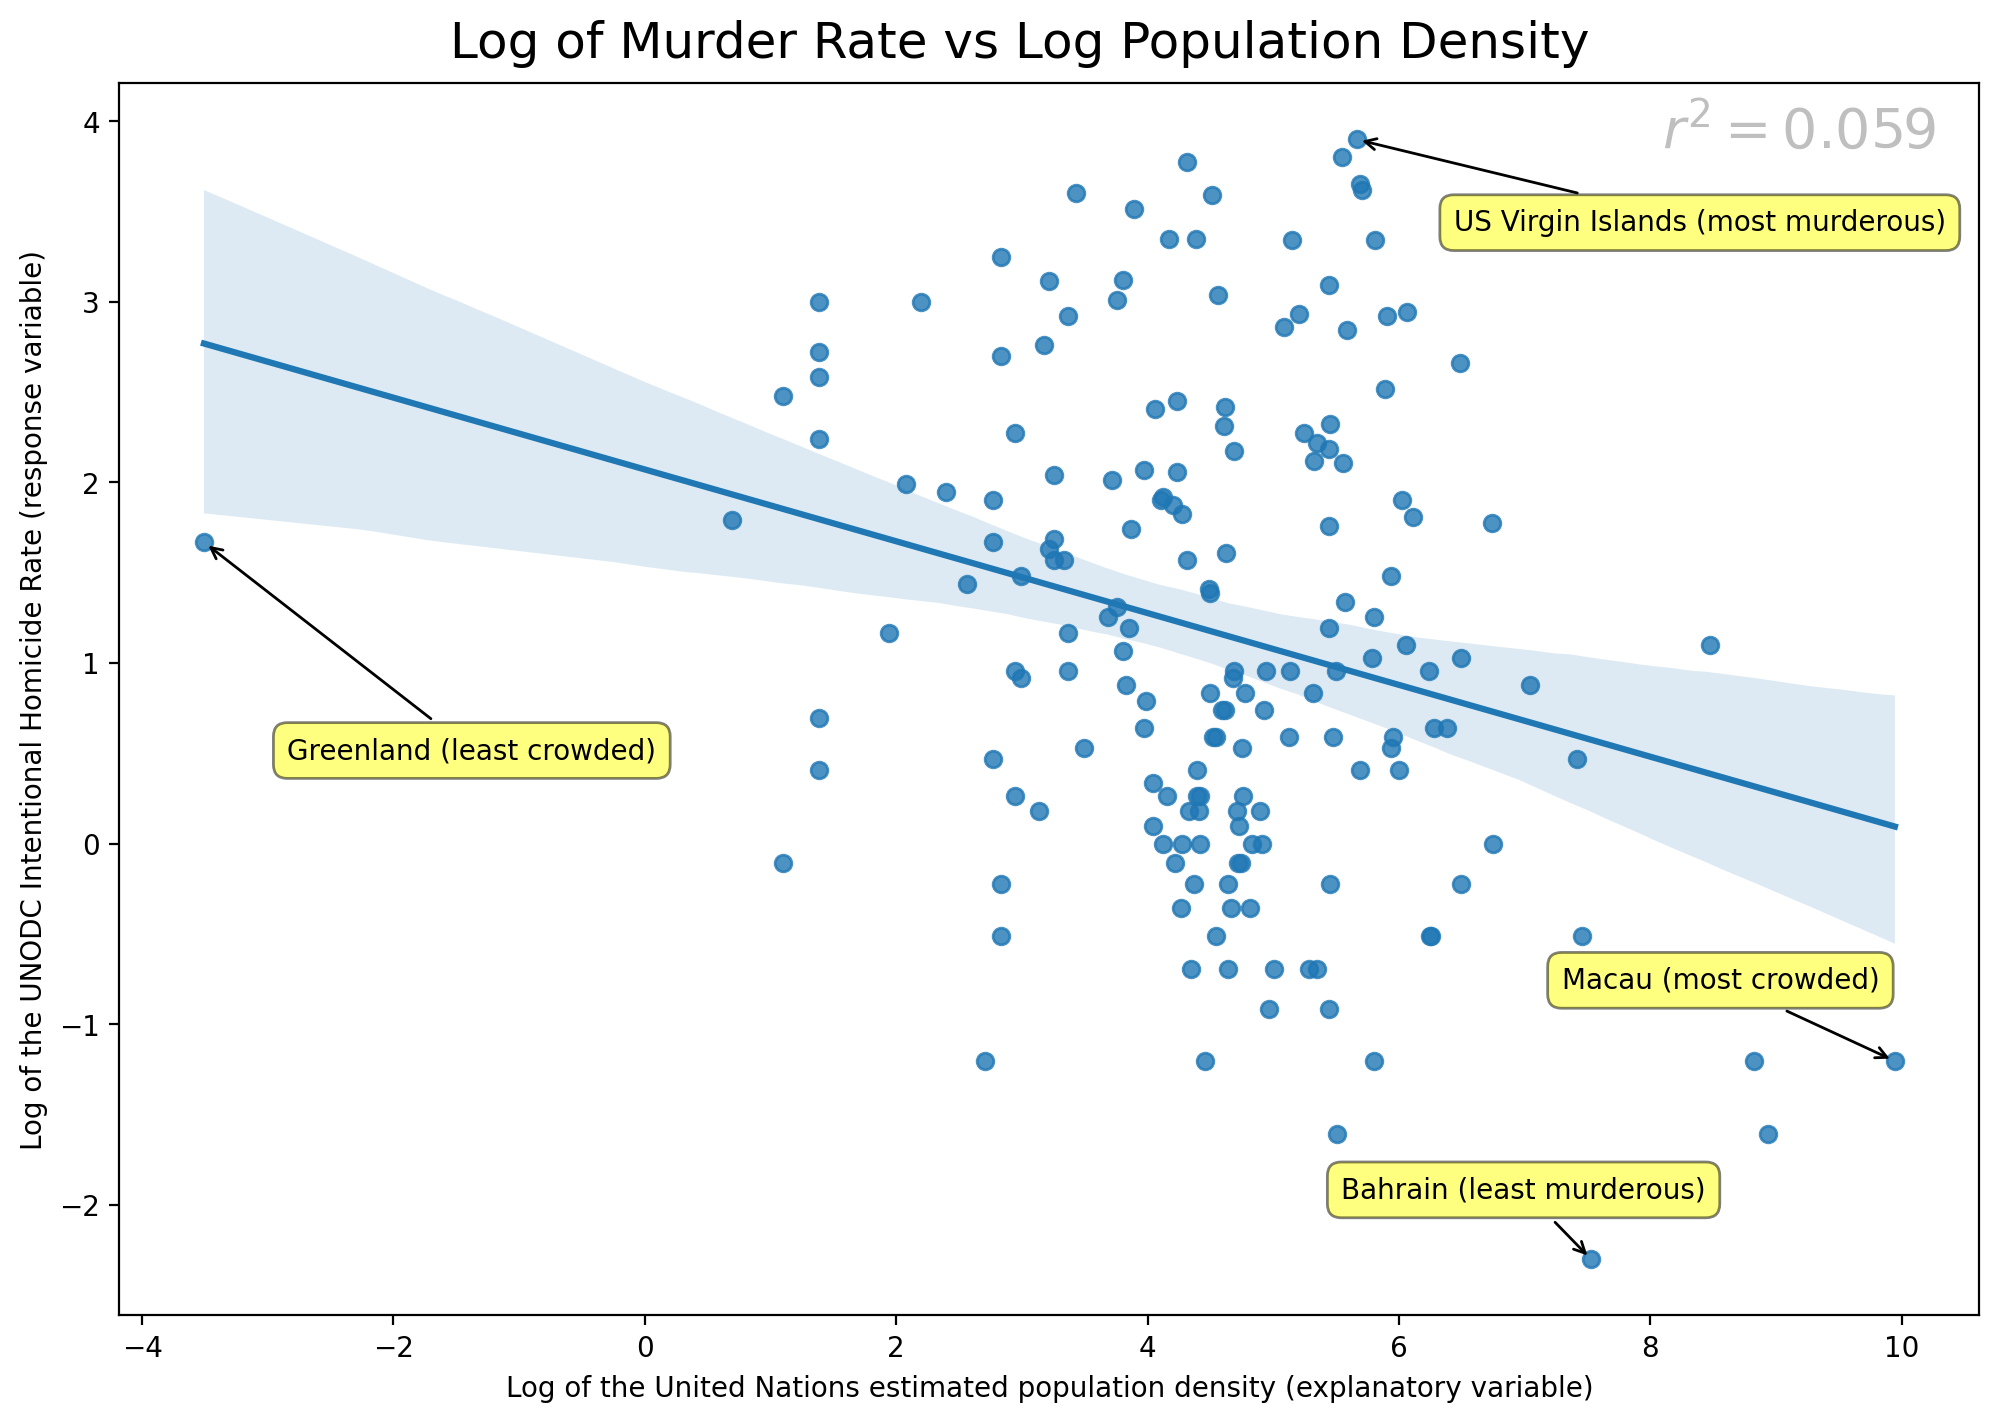

In [266]:

# First order (linear) scatterplot
fig = plt.figure(figsize=(12,8))
merge_axes_subplot = sns.regplot(x=xname, y=yname, scatter=True, data=df)
# xlabel_str = '2016 World Bank estimated GINI index (explanatory variable)'
xlabel_str = 'Log of the United Nations estimated population density (explanatory variable)'
xlabel_text = plt.xlabel(xlabel_str)
ylabel_str = 'Log of the UNODC Intentional Homicide Rate (response variable)'
ylabel_text = plt.ylabel(ylabel_str)
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
least_unequal = xdata.min()
most_unequal = xdata.max()
most_obese = ydata.max()
least_obese = ydata.min()
for label, x, y in zip(df['country_name'], xdata, ydata):
    if (x == least_unequal):
        # annotation = plt.annotate('{} (least unequal)'.format(label),
        annotation = plt.annotate('{} (least crowded)'.format(label),
                                  xy=(x, y), xytext=(30, -80), **kwargs)
    elif (x == most_unequal):
        # annotation = plt.annotate('{} (most unequal)'.format(label),
        annotation = plt.annotate('{} (most crowded)'.format(label),
                                  xy=(x, y), xytext=(-120, 24), **kwargs)
    elif (y == most_obese):
        annotation = plt.annotate('{} (most murderous)'.format(label),
                                  xy=(x, y), xytext=(35, -35), **kwargs)
    elif (y == least_obese):
        annotation = plt.annotate('{} (least murderous)'.format(label),
                                  xy=(x, y), xytext=(-90, 20), **kwargs)
    elif (label == 'USA'):
        annotation = plt.annotate('{} (most evil)'.format(label),
                                  xy=(x, y), xytext=(-75, 25), **kwargs)
# Add r-squared
plt.text(0.825, 0.85, r'$r^2 = {0:.2}$'.format(pearsonr(xdata, ydata)[0] ** 2), fontsize=20, alpha=0.25,
         horizontalalignment='center', verticalalignment='center', transform=fig.transFigure)

# title_str = 'Log of Murder Rate vs Income Inequality'
title_str = 'Log of Murder Rate vs Log Population Density'
title_obj = fig.suptitle(title_str, fontsize=18, y=0.92)


----